In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from model.cnn import CNN
from model.encoder import Encoder
from model.decoder import Decoder
from model.endtoend import HME2LaTeX
from model.language import *
from data_processing.loadData import HMEDataset
import pandas as pd
import numpy as np

## Testing the model on never seen data 

In [2]:
# Load dataset for training
labels_file_train = './data/symbol_train_labels.txt'
images_directory_train = './data/symbol_train_png/'
dataset_train = HMEDataset(labels_file_train, images_directory_train)

# Load dataset for testing
labels_file_test = './data/symbol_test_labels.txt'
images_directory_test = './data/symbol_test_png/'
dataset_test = HMEDataset(labels_file_test, images_directory_test, offset=37440)

BATCH_SIZE = 32

# Runs on GPU if cuda is installed, else on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
dataloader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle=True)

In [4]:
# Create Lang object
latex_train = Lang('latex_train')
latex_test = Lang('latex_test')

# Extract label column from dataset
label_list_train = dataset_train.labels_file.iloc[:,1]
label_list_test = dataset_test.labels_file.iloc[:,1]

# Populate latex language by cycling through label column
for label in label_list_train:
    latex_train.addSentence(label)
for label in label_list_test:
    latex_test.addSentence(label)

# Creates a tensor with each image's label as its index to the latex language
labels_latex_index = [tensorFromSentence(latex_test, i) for i in dataset_test.labels_file.iloc[:,1]]
labels_by_lang_index = torch.cat(labels_latex_index).unsqueeze(1).unsqueeze(0)

In [5]:
# Create model
cnn = CNN(device).to(device)
encoder = Encoder(input_size=512, hidden_size=256, seq_size=(BATCH_SIZE*31), batch_size=BATCH_SIZE).to(device)
decoder = Decoder(input_size=1, hidden_size=512, output_size=100, num_features=32*31, batch_size=BATCH_SIZE, device=device).to(device)
model_4  = HME2LaTeX(cnn, encoder, decoder, labels_by_lang_index.shape[0], BATCH_SIZE, 100, device)
model_10  = HME2LaTeX(cnn, encoder, decoder, labels_by_lang_index.shape[0], BATCH_SIZE, 100, device)
print(model_10)

HME2LaTeX(
  (cnn): CNN(
    (layer1): Sequential(
      (0): ConvNormRelu(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (batchNorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): ConvNormRelu(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (0): ConvNormRelu(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (batchNorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ConvNormRelu(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [6]:
# Get models checkpoints
MODEL_PATH_4 = './symbol_model_4.tar'
checkpoint_4 = torch.load(MODEL_PATH_4)
MODEL_PATH_10 = './symbol_model_10.tar'
checkpoint_10 = torch.load(MODEL_PATH_10)

# Load state dictionary
model_state_dict_4 = checkpoint_4['model_state_dict']
model_4.load_state_dict(model_state_dict_4)
model_state_dict_10 = checkpoint_10['model_state_dict']
model_10.load_state_dict(model_state_dict_10)

# Set in evalutation mode
model_4.eval();
model_10.eval();

In [7]:
correct_4 = 0
for i,(batch_images, batch_labels, batch_indices) in enumerate(dataloader_test):

    # Load data into device
    batch_label_indices = labels_by_lang_index[0][batch_indices].float().to(device)
    batch_images = batch_images.float().to(device)

    # Forward pass through model
    batch_prediction_probabilities_4 = model_4(batch_images, batch_label_indices)[0]
    
    # Add batch accuracy
    batch_predicted_labels_4 = torch.argmax(batch_prediction_probabilities_4, dim=1)
    batch_label_indices = batch_label_indices.squeeze(1).long()
    correct_4 += torch.sum(batch_predicted_labels_4 == batch_label_indices).item()

accuracy_percent_4 = correct_4 / len(dataset_test) * 100
print('Accuracy percent 4 Epochs:', accuracy_percent_4)

Accuracy percent 4 Epochs: 34.979325699745544


In [7]:
correct_10 = 0
for i,(batch_images, batch_labels, batch_indices) in enumerate(dataloader_test):
    
    # Load data into device
    batch_label_indices = labels_by_lang_index[0][batch_indices].float().to(device)
    batch_images = batch_images.float().to(device)
    
    # Forward pass through model
    batch_prediction_probabilities_10 = model_10(batch_images, batch_label_indices)[0]

    # Add batch accuracy
    batch_predicted_labels_10 = torch.argmax(batch_prediction_probabilities_10, dim=1)
    batch_label_indices = batch_label_indices.squeeze(1).long()
    correct_10 += torch.sum(batch_predicted_labels_10 == batch_label_indices).item()

accuracy_percent_10 = correct_10 / len(dataset_test) * 100
print('Accuracy percent 10 Epochs:', accuracy_percent_10)

Accuracy percent 10 Epochs: 34.979325699745544


## Distribution of symbols in the training set

Number of labels: 100
Number of items: 37536


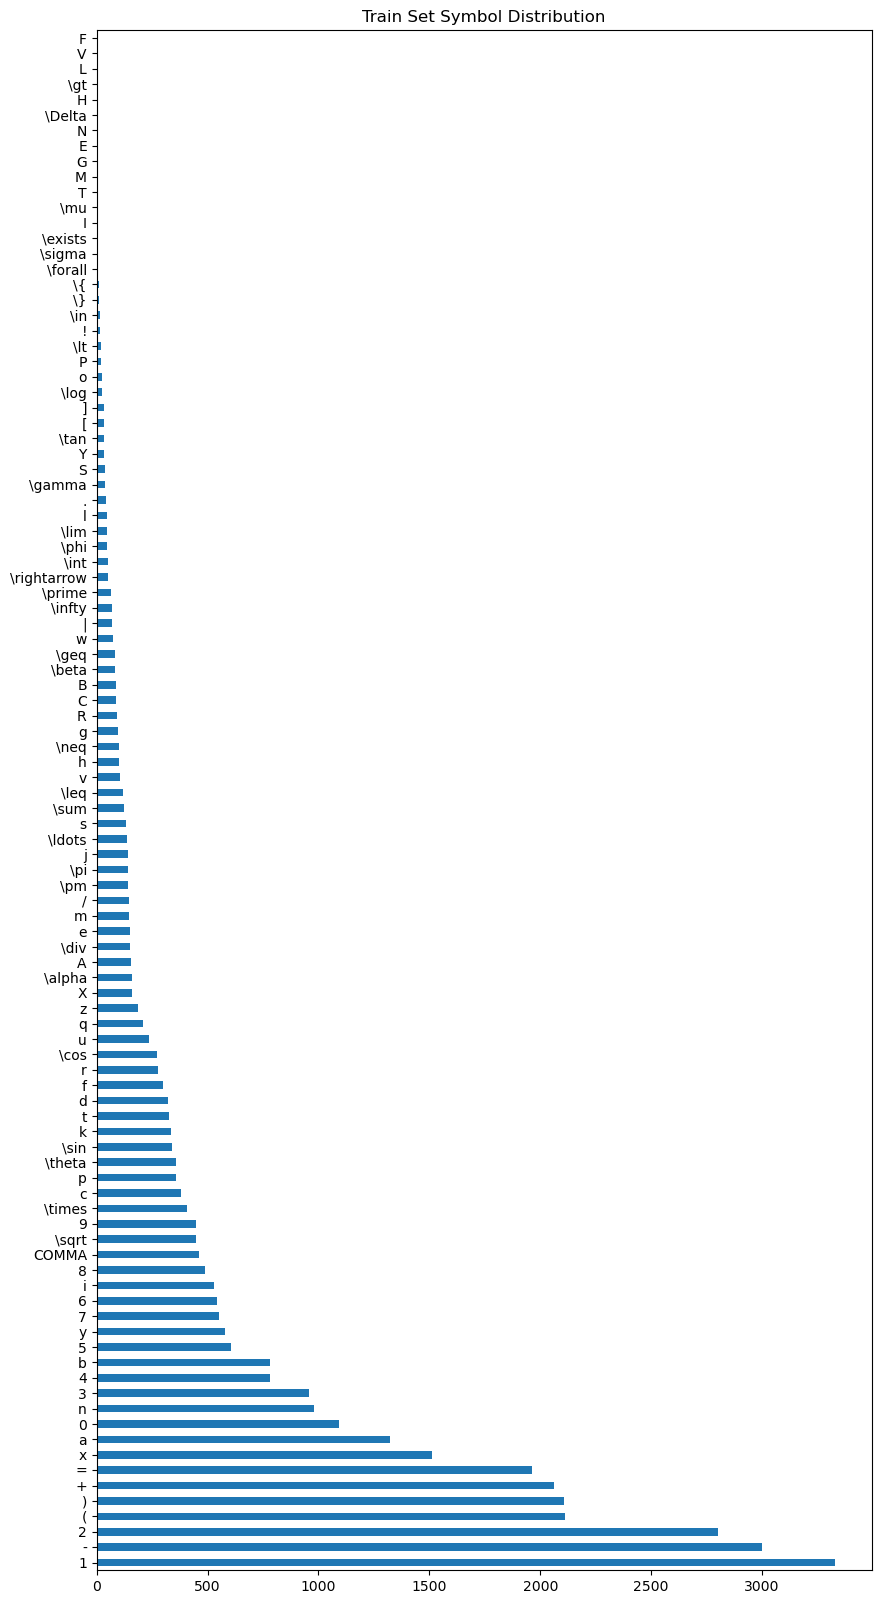

In [7]:
print('Number of labels:', latex_train.n_words)
print('Number of items:', len(dataset_train.labels_file))
dataset_train.labels_file.iloc[:,1].value_counts().plot(kind='barh', figsize=(10,20));
plt.title('Train Set Symbol Distribution');

## Distribution of symbols in the testing set

Number of labels: 55
Number of items: 12576


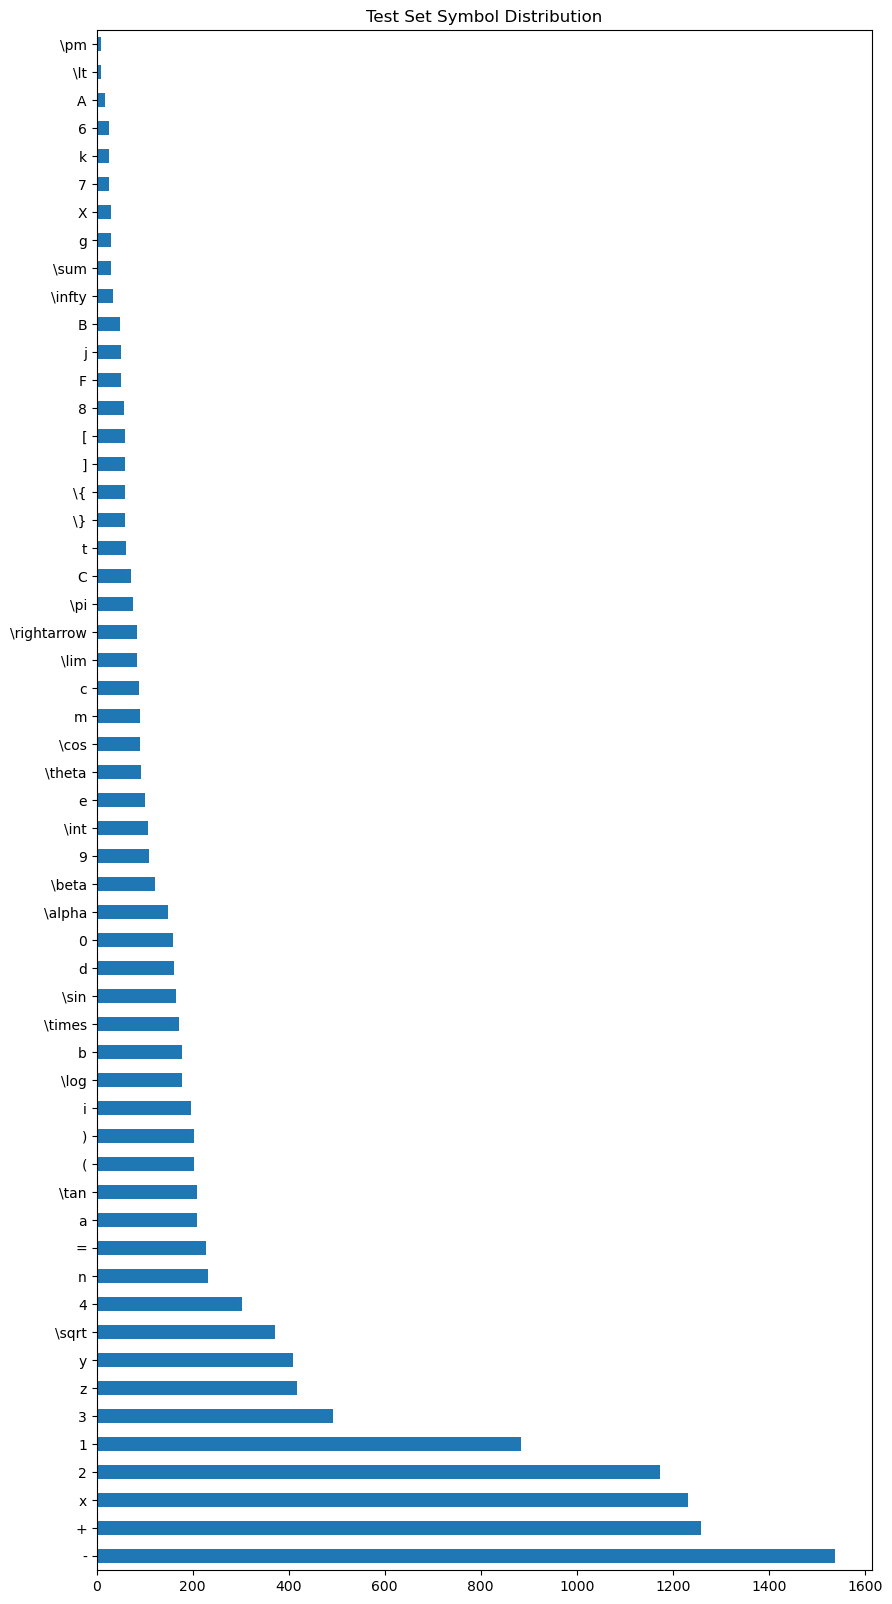

In [8]:
print('Number of labels:', latex_test.n_words)
print('Number of items:', len(dataset_test.labels_file))
dataset_test.labels_file.iloc[:,1].value_counts().plot(kind='barh', figsize=(10,20));
plt.title('Test Set Symbol Distribution');

## Visualization of Information

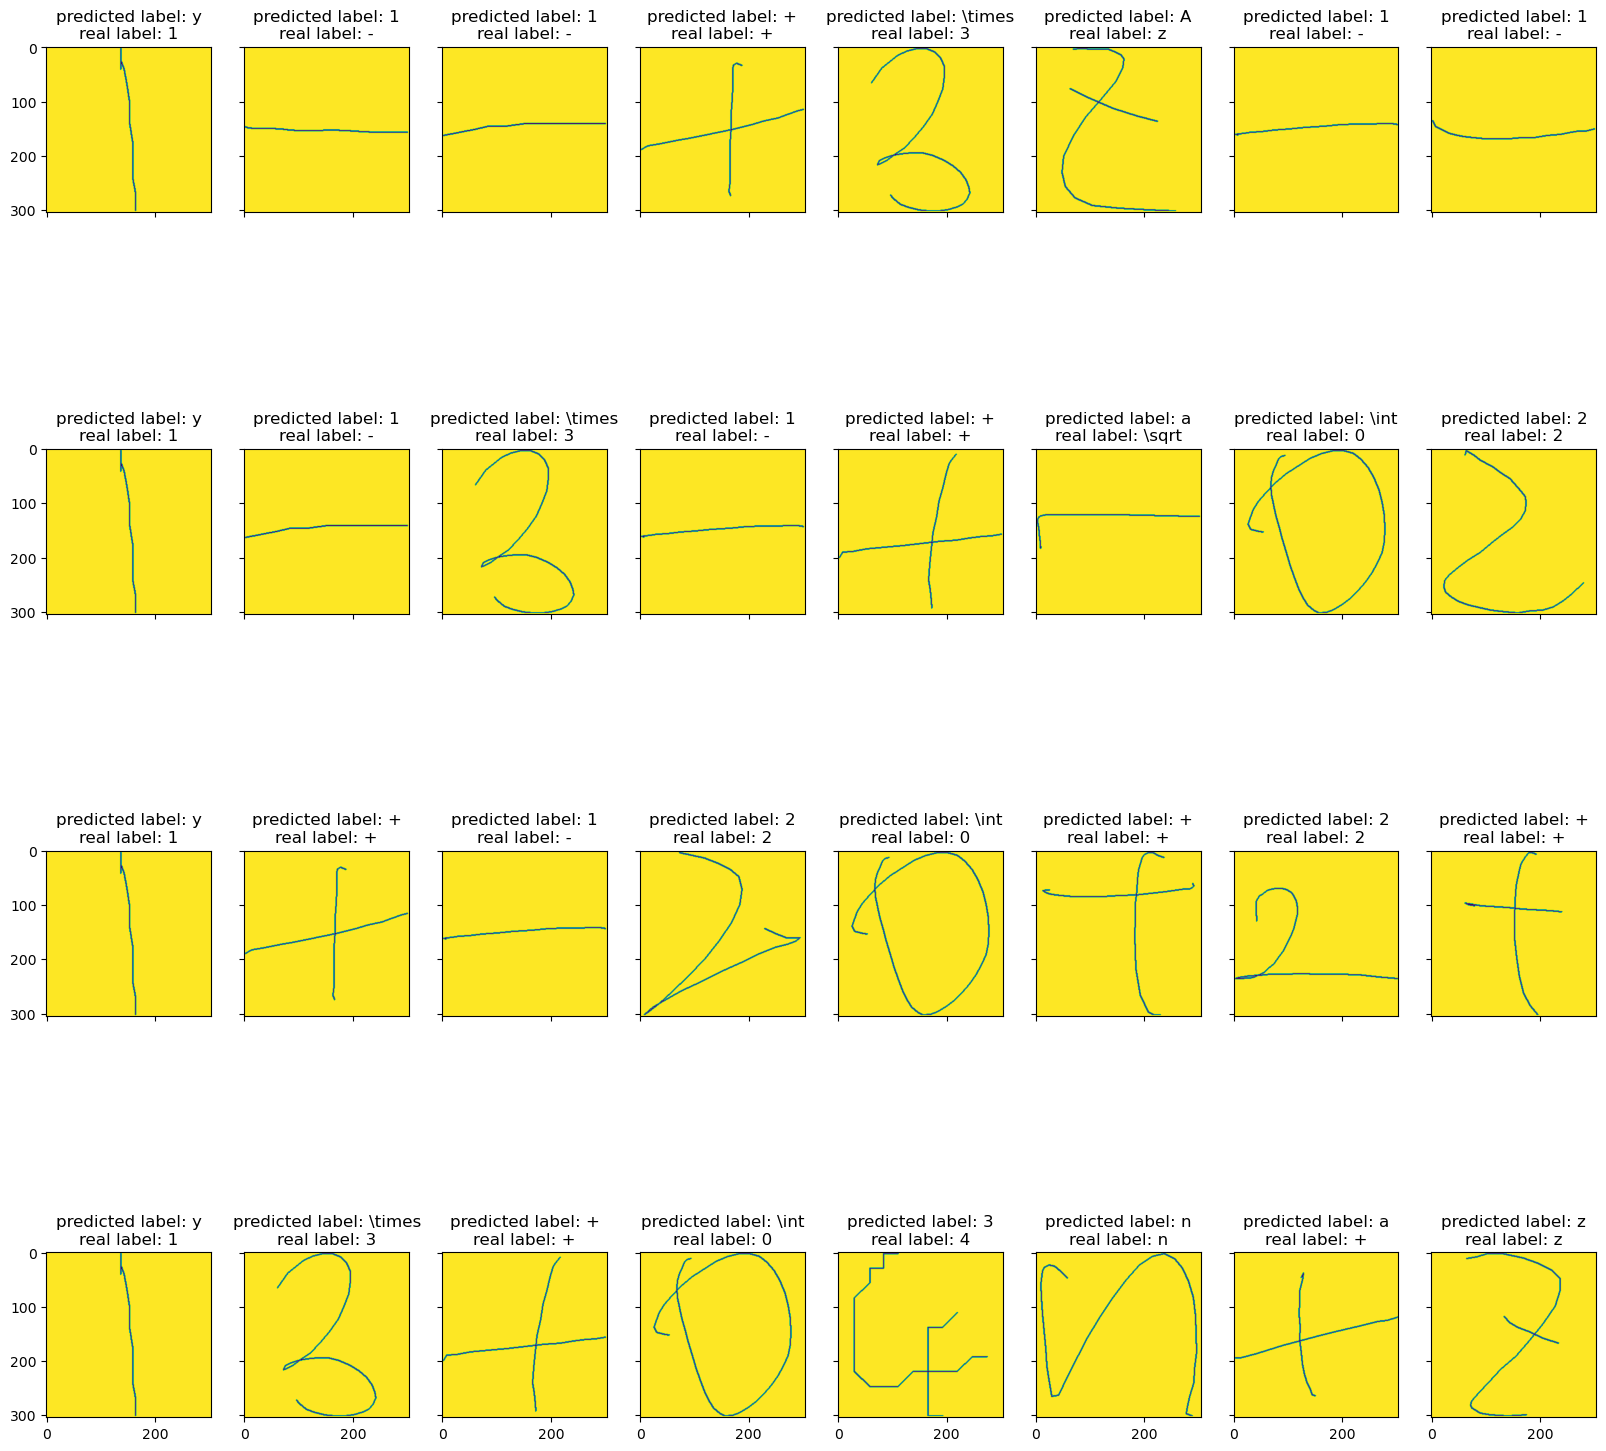

In [9]:
batch_images, batch_labels, batch_indices = next(iter(dataloader_test))

# Load data into device
batch_label_indices = labels_by_lang_index[0][batch_indices].float().to(device)
batch_images = batch_images.float().to(device)

batch_prediction_probabilities = model_4(batch_images, batch_label_indices)[0]
batch_predicted_labels = torch.argmax(batch_prediction_probabilities, dim=1)

numpy_images = batch_images.cpu().numpy()
fig,axs = plt.subplots(4,8, figsize=(20,20))
for i in range(4):
    for j in range(8):
        axs[i,j].imshow(numpy_images[(i+1)*j].reshape((304,304)))
        axs[i,j].set_title(f'predicted label: {latex_test.index2word[batch_predicted_labels[(i+1)*j].item()]}\nreal label: {batch_labels[(i+1)*j]}')
        axs[i,j].label_outer()